## O2-O2- and O2-N2 theoretical CIA model reported by Karaman et al

In [8]:
import numpy as np
import pandas as pd
import qgrid
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


import MATS

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")

In [9]:
from MATS.linelistdata import linelistdata
PARAM_LINELIST = linelistdata['Singlet_Delta_Linelist_JQSRT_270_2021_107684']
PARAM_LINELIST.sort_values('nu', inplace = True)



C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ema3\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


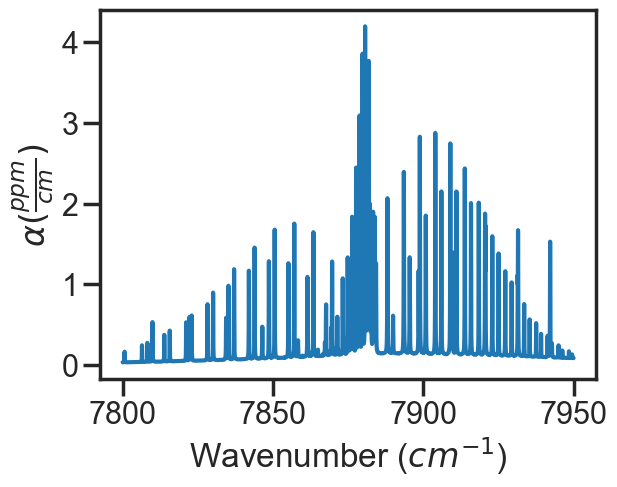

In [11]:
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-26 #intensities must be above this value for the line to be fit
order_baseline_fit = 0


wave_min = 7800  #cm-1
wave_max = 7950 #cm-1
wave_space = 0.005 #cm-1
wavenumbers = np.arange(wave_min, wave_max, 0.02)


def sim_spectra_with_CIA(pressure, temperature, sample_molefraction, filename):
    Diluent = {'O2': {'composition':sample_molefraction[7], 'm': 31.998}, 'N2': {'composition':1-sample_molefraction[7], 'm': 28.0134}}
    spec =  MATS.simulate_spectrum(PARAM_LINELIST, wavenumbers = wavenumbers, 
                         baseline_terms = baseline_terms, temperature = temperature,  pressure = pressure,
                         molefraction = sample_molefraction, Diluent = Diluent,
                         filename = filename)
    # Adjusted from Initial guess derived based HITRAN 2020 reported theoretical CIA
    EXCH_c, EXCH_b, EXCH_a = [3.63e-06, 0.003, 1]
    SO_c, SO_b, SO_a =[1.5e-06, 0.0002, 1]
    SO_O2, SO_N2, EXCH_O2 = [40, 75 ,315] 

    CIA = MATS.o2_cia_karman_model(wavenumbers, temperature + 273.15, pressure/760, Diluent,
                            SO_O2, SO_N2, EXCH_O2, 
                            EXCH_b, EXCH_c, #O2-O2
                            SO_b, SO_c, #O2-N2
                            SO_b, SO_c, 
                            SO_shift_O2_O2 = 0, SO_shift_O2_N2 = 0, EXCH_shift = 0,
                            band = 'singlet_delta')
    spec.alpha += CIA
    return spec

spec_1 = sim_spectra_with_CIA(760, 22.85, {7 :0.2095}, 'Air_296')
spec_2 = sim_spectra_with_CIA(760, 0, {7 :0.2095}, 'Air_296')
spec_3 = sim_spectra_with_CIA(760, 50, {7 :0.2095}, 'Air_296')
spec_4 = sim_spectra_with_CIA(760, 22.85, {7 :1}, 'O2_296')
spec_5 = sim_spectra_with_CIA(760, 0, {7 :1}, 'O2_296')
spec_6 = sim_spectra_with_CIA(760, 50, {7 :1}, 'O2_296')


spec_1.plot_wave_alpha()

In [12]:
#Add all spectrum to a Dataset object
SPECTRA = MATS.Dataset([spec_1, spec_2, spec_3, spec_4, spec_5, spec_6], 
                       'Experimental Singlet Delta with CIA', PARAM_LINELIST, CIA_model = {'model':'Karman', 'band': 'singlet_delta'})

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
CIA_LINELIST = SPECTRA.generate_CIA_paramlist()
CIA_LINELIST

,CIA Pair,S_SO,S_EXCH,EXCH_b,EXCH_c,SO_b,SO_c,SO_shift,EXCH_shift
0,O2_O2,39.13,304.744817,0.002839,0.000004,0.000146,0.000001,0,0
1,O2_N2,70.74,0.000000,0.000000,0.000000,0.000146,0.000001,0,0


In [13]:
FITPARAMS = MATS.Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, CIA_linelist = CIA_LINELIST, 
                                        lineprofile = 'SDNGP', linemixing = True, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = True, sw_constrain = True, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:False, 2:False, 3:False}}, vary_sw = {7:{1:False, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:False}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:False}}, 
                                                    vary_aw = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = False, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= False, vary_etalon_period= False, vary_etalon_phase= False, 
                                         vary_pressure = False, vary_temperature = False)
FITPARAMS.generate_fit_KarmanCIA_linelist(vary_S_SO = True, vary_S_EXCH = True, 
                                        vary_EXCH_temp = True, vary_SO_temp = True, 
                                        vary_EXCH_shift = True, vary_SO_shift = True)

,CIA Pair,S_SO,S_SO_err,S_SO_vary,S_EXCH,S_EXCH_err,S_EXCH_vary,EXCH_b,EXCH_b_err,EXCH_b_vary,...,SO_b_vary,SO_c,SO_c_err,SO_c_vary,SO_shift,SO_shift_err,SO_shift_vary,EXCH_shift,EXCH_shift_err,EXCH_shift_vary
0,O2_O2,39.13,0,True,304.744817,0,True,0.002839,0,True,...,True,0.000001,0,True,0,0,True,0,0,True
1,O2_N2,70.74,0,True,0.000000,0,True,0.000000,0,True,...,True,0.000001,0,True,0,0,True,0,0,True


In [ ]:
fit_data = MATS.Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', CIA_linelist_file = 'CIA_LineList',
                            minimum_parameter_fit_intensity = Fit_Intensity)
params = fit_data.generate_params()
params = fit_data.constrained_CIA(params)
for param in params:
    if 'S_SO' in param:
        params[param].set(min = 0.00)
    if 'S_EXCH' in param:
        params[param].set(min = 0.00)

result = fit_data.fit_data(params, wing_wavenumbers = 25,  wing_method = 'wing_wavenumbers')
fit_data.residual_analysis(result, indv_resid_plot=False)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()



In [7]:
result.params

C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in longlong_scalars
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))
C:\Users\ema3\Anaconda3\lib\site-packages\lmfit\printfuncs.py:321: RuntimeWarning: invalid value encountered in true_divide
  spercent = '({:.2%})'.format(abs(par.stderr/par.value))


name,value,standard error,relative error,initial value,min,max,vary,expression
Pressure_1_1,0.65768052,0.00000000,(0.00%),0.6576805180396587,-inf,inf,False,
Temperature_1_1,296.476600,0.00000000,(0.00%),296.4766000549867,-inf,inf,False,
x_shift_1_1,0.00000000,0.00000000,(nan%),0.0,-0.01000000,0.01000000,False,
molefraction_O2_1_1,0.20884597,6.3827e-06,(0.00%),0.209323,0.10000000,1.10000000,True,
molefraction_H2O_1_1,1.0000e-06,0.00000000,(0.00%),1e-06,0.00000000,1.0000e-04,False,
baseline_a_1_1,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
baseline_b_1_1,0.00000000,0.00000000,(nan%),0.0,-inf,inf,False,
Pressure_2_1,0.98763207,0.00000000,(0.00%),0.9876320698366908,-inf,inf,False,
Temperature_2_1,296.495408,0.00000000,(0.00%),296.4954080381151,-inf,inf,False,
x_shift_2_1,0.00000000,0.00000000,(nan%),0.0,-0.01000000,0.01000000,False,
